In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.power import TTestIndPower
from scipy.stats import norm
from scipy.stats import chi2
from IPython.display import display, HTML
from matplotlib_venn import venn2
from scipy.stats import fisher_exact
from scipy.stats import mannwhitneyu
from scipy.stats import pearsonr
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [2]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv("/Users/anasouza/Documents/A3Data/churn_telefone/churn/Customer-Churn - Customer-Churn.csv")

In [4]:
df.shape

(7043, 21)

In [5]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7569-NMZYQ,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),"118,75","8672,45",No
1,8984-HPEMB,Female,0,No,No,71,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Electronic check,"118,65","8477,6",No
2,5989-AXPUC,Female,0,Yes,No,68,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Mailed check,"118,6","7990,05",No
3,5734-EJKXG,Female,0,No,No,61,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,One year,Yes,Electronic check,"118,6","7365,7",No
4,8199-ZLLSA,Male,0,No,No,67,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,One year,Yes,Bank transfer (automatic),"118,35","7804,15",Yes


In [6]:
def plot_value_counts(data, column_name):
    """
    Plot the value counts of unique values in a specific column of a DataFrame.

    Parameters:
        data (pd.DataFrame): The DataFrame containing the data.
        column_name (str): The name of the column for which to plot value counts.

    Returns:
        None
    """
    value_counts = data[column_name].value_counts()
    
    plt.bar(value_counts.index.astype(str), value_counts.values)
    plt.xlabel(column_name)
    plt.ylabel('Count')
    plt.title(f'Value Counts of {column_name}')
    plt.xticks(rotation=45)  # Rotating x-axis labels for better readability

    # Adding count labels on top of bars
    for i, count in enumerate(value_counts.values):
        plt.text(i, count + 10, str(count), ha='center', va='bottom', fontsize=10)
        print(count/len(df))
    
    
    plt.show()

0.7346301292063041
0.2653698707936959


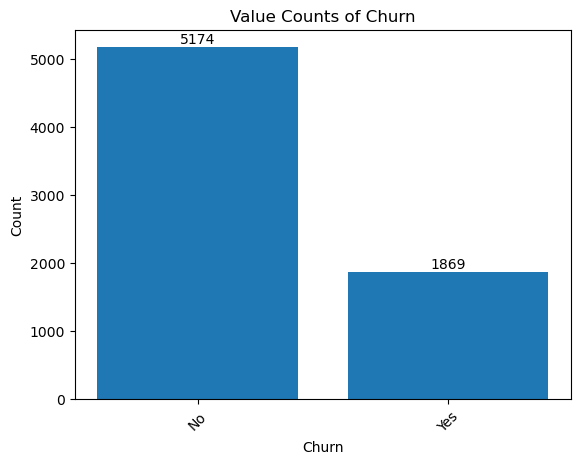

In [7]:
plot_value_counts(df, "Churn")

In [8]:
(df.Churn.value_counts()/len(df)).round(2)

No     0.73
Yes    0.27
Name: Churn, dtype: float64

In [9]:
print(f"before null removal = {df.shape}")
df = df.dropna()
print(f"after removal  = {df.shape}")

before null removal = (7043, 21)
after removal  = (7032, 21)


In [10]:
def process_dataframe_columns(df):
    """
    Process columns in a DataFrame with two or more but less than five unique values.

    Args:
        df (pd.DataFrame): The input DataFrame to process.

    Returns:
        None: The function modifies the input DataFrame in place.
    """
    # Identify columns with only two unique values
    num_uniques = pd.DataFrame(df.nunique())
    only_two = num_uniques.loc[num_uniques[0] == 2].index.tolist()

    # Replace specific values in columns with two unique values
    for col in only_two:
        df[col] = df[col].replace({"Yes": 1, "No": 0, "Female": 1, "Male": 0})

    # Convert columns with two unique values to integer type
    for col in only_two:
        try:
            df[col] = df[col].astype(int)
        except:
            pass

    # Identify columns with more than two but less than five unique values
    more_than_two_less_than_five = num_uniques.loc[(num_uniques[0] > 2) & (num_uniques[0] < 5)].index.tolist()

    # Replace specific values in columns with more than two but less than five unique values
    for col in more_than_two_less_than_five:
        df[col] = df[col].replace({"Yes": 1, "No": 0, "No phone service": np.nan, "No internet service": np.nan})

    # Convert columns with more than two but less than five unique values to integer type
    for col in more_than_two_less_than_five:
        try:
            df[col] = df[col].astype(int)
        except:
            pass

    df["MonthlyCharges"] = df["MonthlyCharges"].str.replace(",",".")
    df["TotalCharges"] = df["TotalCharges"].str.replace(",",".")

    df["MonthlyCharges"]  = df["MonthlyCharges"].astype(float)
    df["TotalCharges"]  = df["TotalCharges"].astype(float)

    df["internet_phone"] = np.where((df["PhoneService"] ==1 ) & 
                                (df["InternetService"] != 0), 1, 0)


In [11]:
process_dataframe_columns(df)

In [12]:
multicat = []
binary = []
few_cat = []
for i in df.columns:
    if df[i].nunique() != 2:
        multicat.append(i)
    if df[i].nunique() == 2:
        binary.append(i)
    if (df[i].nunique() > 2) and (df[i].nunique() < 5):
        few_cat.append(i)

In [13]:
churned = df.loc[df["Churn"] == 1]
active = df.loc[df["Churn"] == 0]

## Total Charges

In [16]:
active["TotalCharges"].mean()

2555.3441410032933

In [17]:
active["TotalCharges"].describe()

count    5163.000000
mean     2555.344141
std      2329.456984
min        18.800000
25%       577.825000
50%      1683.600000
75%      4264.125000
max      8672.450000
Name: TotalCharges, dtype: float64

<Axes: >

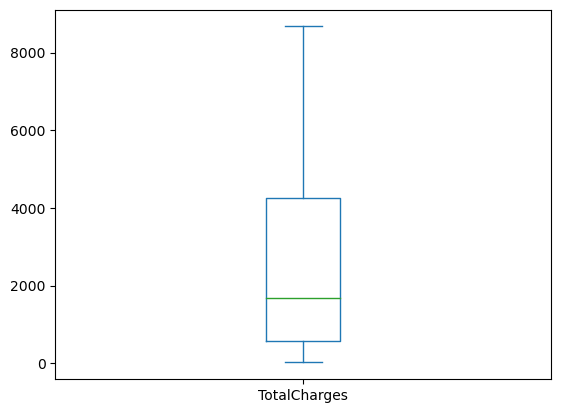

In [18]:
active["TotalCharges"].plot(kind="box")

## Montly Charges

In [19]:
active["MonthlyCharges"].mean()

61.2651236954

In [20]:
active["MonthlyCharges"].describe()

count    5174.000000
mean       61.265124
std        31.092648
min        18.250000
25%        25.100000
50%        64.425000
75%        88.400000
max       118.750000
Name: MonthlyCharges, dtype: float64

<Axes: >

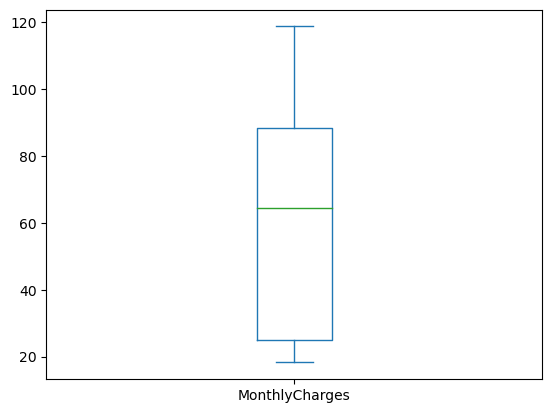

In [21]:
active["MonthlyCharges"].plot(kind="box")

## Bar plot

0.4402730375426621
0.3435722411831627
0.2161547212741752


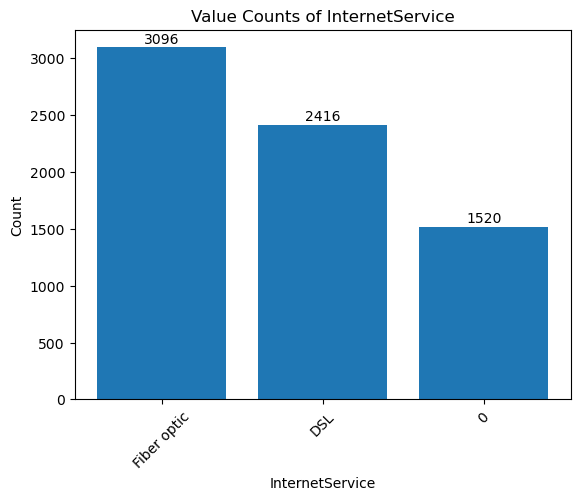

0.551052332195677
0.2396188850967008
0.20932878270762229


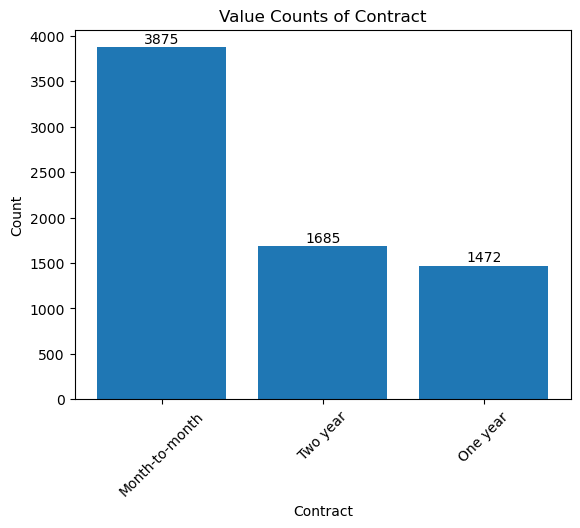

0.3363196814562002
0.22810011376564276
0.21928327645051193
0.21629692832764505


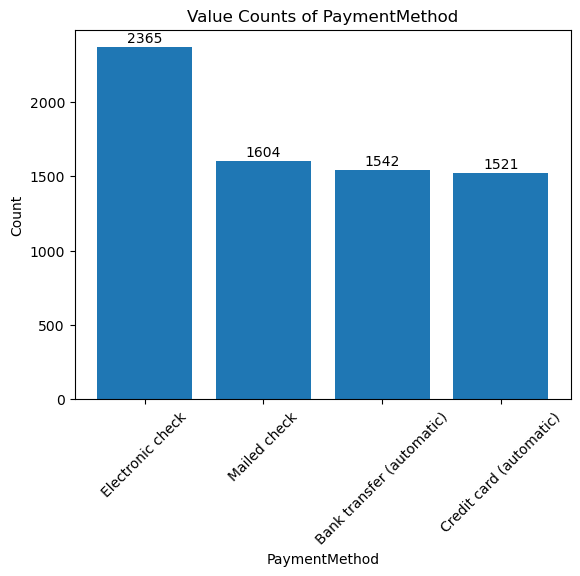

In [14]:
for i in few_cat:
    plot_value_counts(df, i)

0.5046928327645052
0.4953071672354949


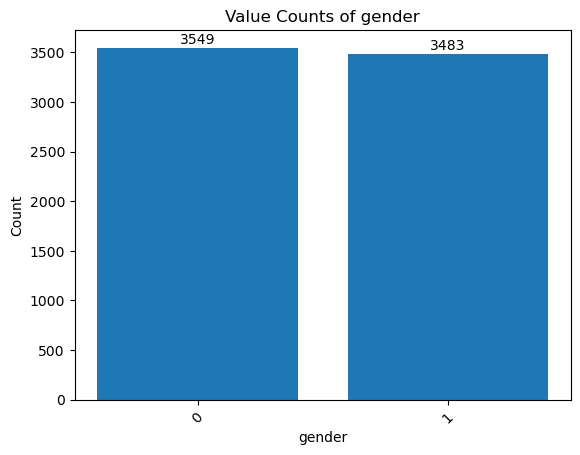

0.8375995449374289
0.16240045506257111


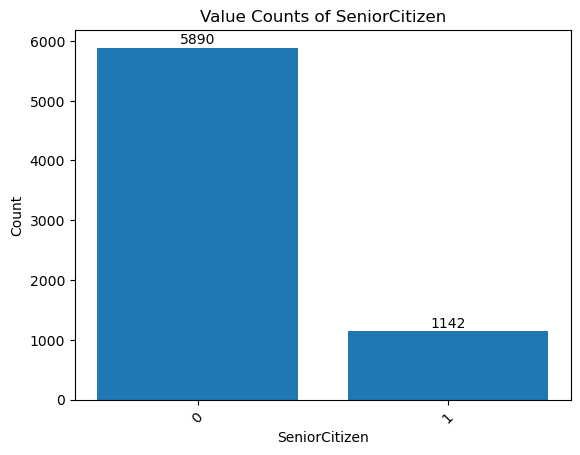

0.5174914675767918
0.4825085324232082


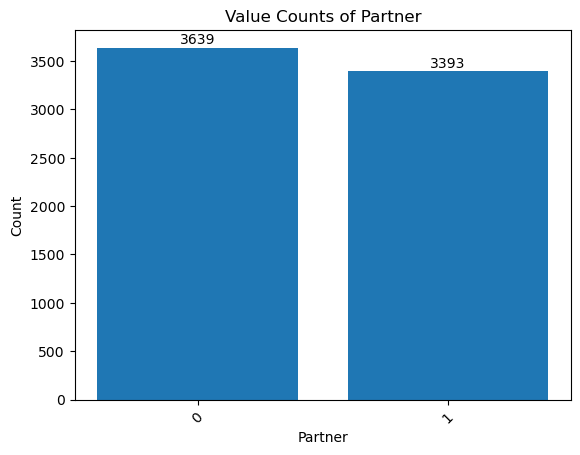

0.7015073947667805
0.2984926052332196


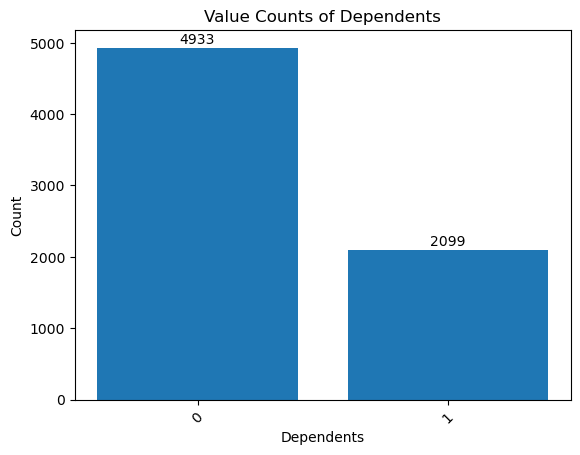

0.9032992036405005
0.09670079635949944


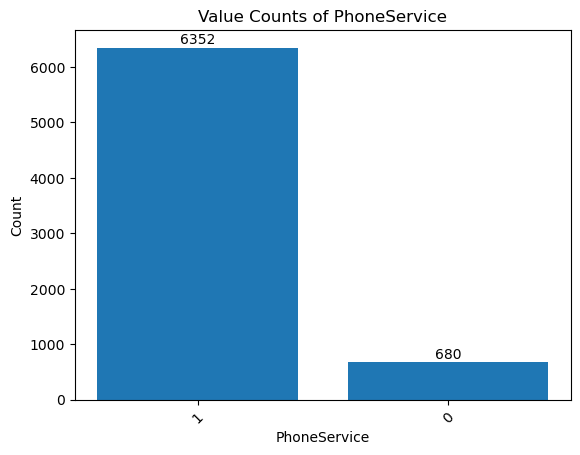

0.48137087599544937
0.42192832764505117


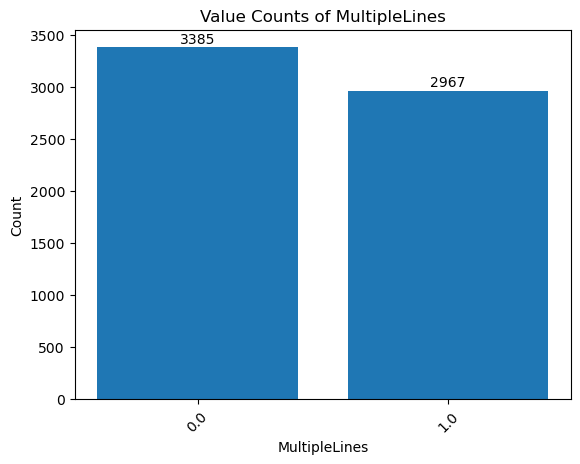

0.49729806598407283
0.286547212741752


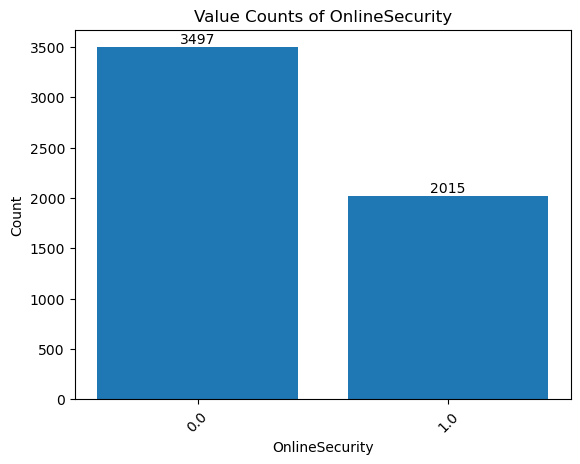

0.43899317406143346
0.34485210466439137


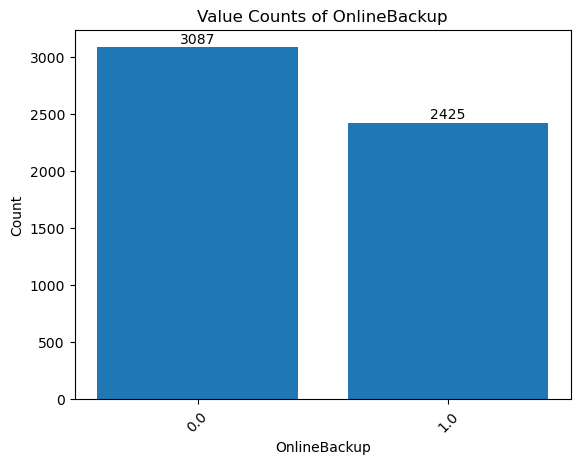

0.4399886234357224
0.3438566552901024


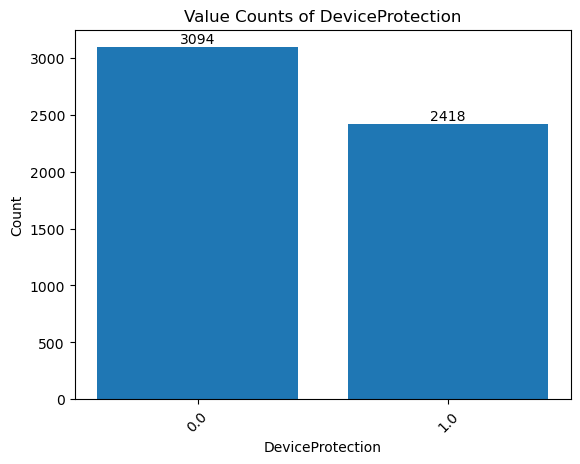

0.4937428896473265
0.2901023890784983


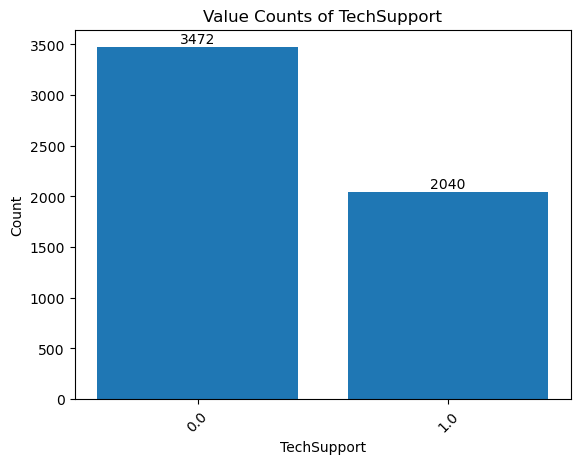

0.39945961319681456
0.3843856655290102


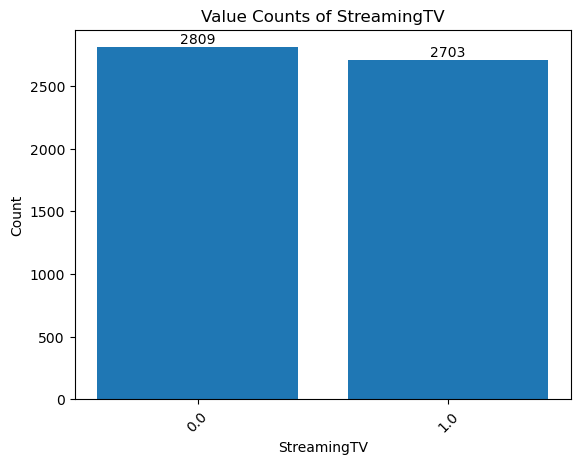

0.39547781569965873
0.3883674630261661


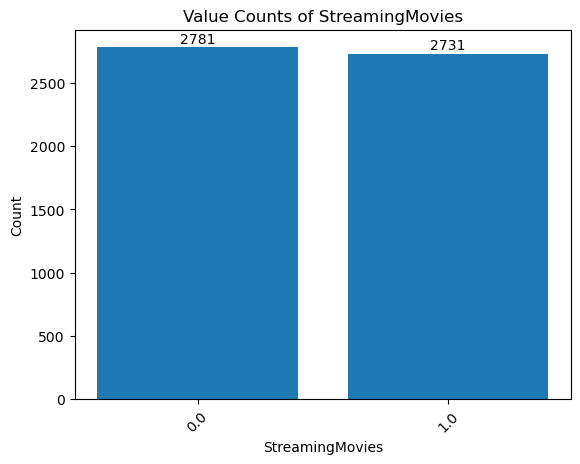

0.5927189988623436
0.4072810011376564


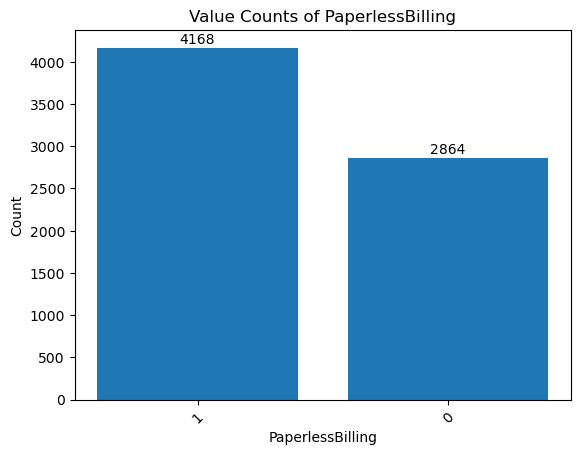

0.7342150170648464
0.26578498293515357


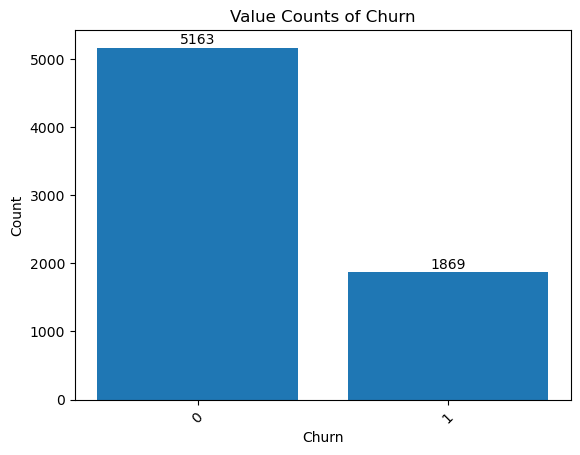

0.6871444823663254
0.31285551763367464


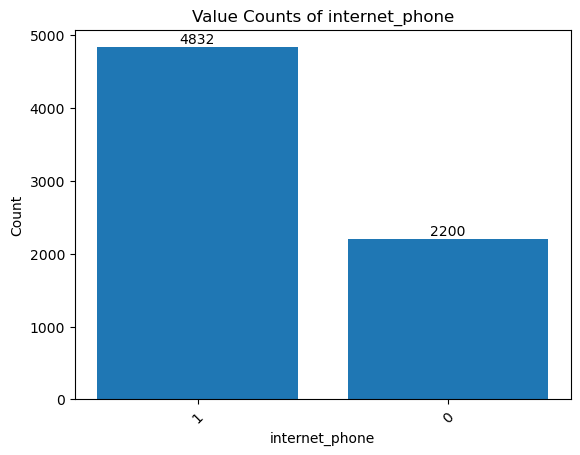

In [15]:
for i in binary:
    plot_value_counts(df, i)

In [16]:
churned.shape[0]

1869

In [17]:
df.loc[df["InternetService"] != 0].shape[0]/len(df)

0.7838452787258248

In [18]:
df.loc[(df["InternetService"] != 0) & 
       (df["PhoneService"] != 0) & 
       (df["Churn"] == 1)].shape[0]

1586

In [19]:
df.loc[(df["InternetService"] != 0) & 
       (df["PhoneService"] == 0) & 
       (df["Churn"] == 1)].shape[0]

170

In [20]:
df.loc[(df["InternetService"] == 0) & 
       (df["PhoneService"] != 0) & 
       (df["Churn"] == 1)].shape[0]

113

## Difference in Tenure Between Churn and No Churn

In [21]:
df.describe().round(2)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,internet_phone
count,7032.0,7032.00,7032.00,7032.00,7032.00,7032.0,6352.00,5512.00,5512.00,5512.00,5512.00,5512.00,5512.0,7032.00,7032.00,7032.00,7032.00,7032.00
mean,0.5,0.16,0.48,0.30,32.42,0.9,0.47,0.37,0.44,0.44,0.37,0.49,0.5,0.59,64.80,2283.30,0.27,0.69
std,0.5,0.37,0.50,0.46,24.55,0.3,0.50,0.48,0.50,0.50,0.48,0.50,0.5,0.49,30.09,2266.77,0.44,0.46
min,0.0,0.00,0.00,0.00,1.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,18.25,18.80,0.00,0.00
25%,0.0,0.00,0.00,0.00,9.00,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,35.59,401.45,0.00,0.00
50%,0.0,0.00,0.00,0.00,29.00,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,1.00,70.35,1397.48,0.00,1.00
75%,1.0,0.00,1.00,1.00,55.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.00,89.86,3794.74,1.00,1.00
max,1.0,1.00,1.00,1.00,72.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.00,118.75,8684.80,1.00,1.00


In [22]:
churned.describe().round(2)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,internet_phone
count,1869.0,1869.00,1869.00,1869.00,1869.00,1869.00,1699.0,1756.00,1756.00,1756.00,1756.00,1756.00,1756.00,1869.00,1869.00,1869.00,1869.0,1869.00
mean,0.5,0.25,0.36,0.17,17.98,0.91,0.5,0.17,0.30,0.31,0.18,0.46,0.47,0.75,74.44,1531.80,1.0,0.85
std,0.5,0.44,0.48,0.38,19.53,0.29,0.5,0.37,0.46,0.46,0.38,0.50,0.50,0.43,24.67,1890.82,0.0,0.36
min,0.0,0.00,0.00,0.00,1.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,18.85,18.85,1.0,0.00
25%,0.0,0.00,0.00,0.00,2.00,1.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,56.15,134.50,1.0,1.00
50%,1.0,0.00,0.00,0.00,10.00,1.00,1.0,0.00,0.00,0.00,0.00,0.00,0.00,1.00,79.65,703.55,1.0,1.00
75%,1.0,1.00,1.00,0.00,29.00,1.00,1.0,0.00,1.00,1.00,0.00,1.00,1.00,1.00,94.20,2331.30,1.0,1.00
max,1.0,1.00,1.00,1.00,72.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,118.35,8684.80,1.0,1.00


In [23]:
active.describe().round(2)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,internet_phone
count,5163.00,5163.00,5163.00,5163.00,5163.00,5163.0,4653.00,3756.00,3756.00,3756.0,3756.00,3756.0,3756.00,5163.00,5163.00,5163.00,5163.0,5163.00
mean,0.49,0.13,0.53,0.34,37.65,0.9,0.45,0.46,0.51,0.5,0.46,0.5,0.51,0.54,61.31,2555.34,0.0,0.63
std,0.50,0.34,0.50,0.47,24.08,0.3,0.50,0.50,0.50,0.5,0.50,0.5,0.50,0.50,31.09,2329.46,0.0,0.48
min,0.00,0.00,0.00,0.00,1.00,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,18.25,18.80,0.0,0.00
25%,0.00,0.00,0.00,0.00,15.00,1.0,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,25.10,577.83,0.0,0.00
50%,0.00,0.00,1.00,0.00,38.00,1.0,0.00,0.00,1.00,0.0,0.00,1.0,1.00,1.00,64.45,1683.60,0.0,1.00
75%,1.00,0.00,1.00,1.00,61.00,1.0,1.00,1.00,1.00,1.0,1.00,1.0,1.00,1.00,88.48,4264.12,0.0,1.00
max,1.00,1.00,1.00,1.00,72.00,1.0,1.00,1.00,1.00,1.0,1.00,1.0,1.00,1.00,118.75,8672.45,0.0,1.00


In [24]:
# Define a custom color palette
custom_palette = sns.color_palette("coolwarm", as_cmap=True)

<Axes: >

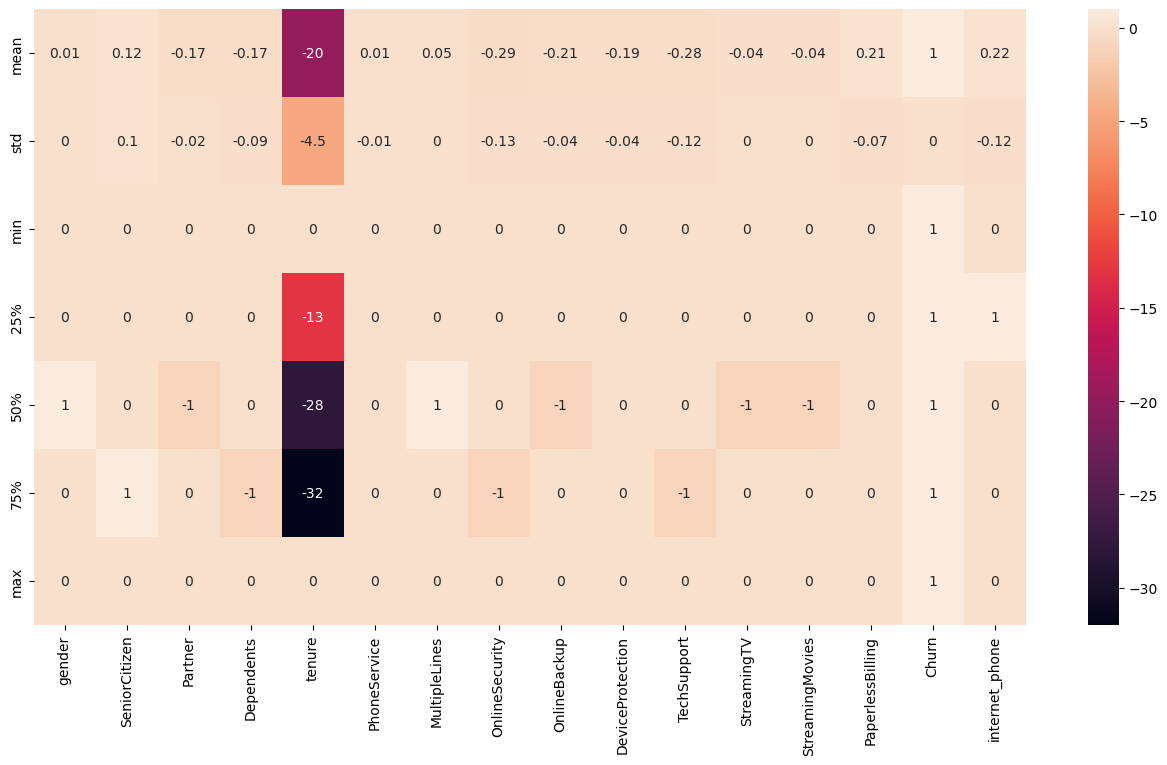

In [25]:
differences_descript = churned.describe().round(2) - active.describe().round(2)
differences_descript = differences_descript.iloc[1:,:]
differences_descript = differences_descript.drop(["MonthlyCharges","TotalCharges"], axis=1)
plt.figure(figsize=(16, 8)) 
sns.heatmap(differences_descript,annot=True)

In [26]:
df.describe(include="object")

,customerID,InternetService,Contract,PaymentMethod
count,7032,7032,7032,7032
unique,7032,3,3,4
top,7569-NMZYQ,Fiber optic,Month-to-month,Electronic check
freq,1,3096,3875,2365


In [27]:
churned.describe(include="object")

,customerID,InternetService,Contract,PaymentMethod
count,1869,1869,1869,1869
unique,1869,3,3,4
top,8199-ZLLSA,Fiber optic,Month-to-month,Electronic check
freq,1,1297,1655,1071


In [28]:
active.describe(include="object")

,customerID,InternetService,Contract,PaymentMethod
count,5163,5163,5163,5163
unique,5163,3,3,4
top,7569-NMZYQ,DSL,Month-to-month,Mailed check
freq,1,1957,2220,1296


## Histogram

In [55]:
def plot_columns_side_by_side(df, columns, title="", rotation=0, hue=None):
    fig, axes = plt.subplots(1, len(columns), figsize=(15, 5))
    fig.suptitle(title)
    
    for i, col in enumerate(columns):
        if hue:
            sns.countplot(data=df, x=col, ax=axes[i], hue=hue)
        else:
            df[col].value_counts().plot(kind="bar", ax=axes[i], rot=rotation)
        
        axes[i].set_title(col)
    
    plt.tight_layout()
    plt.show()


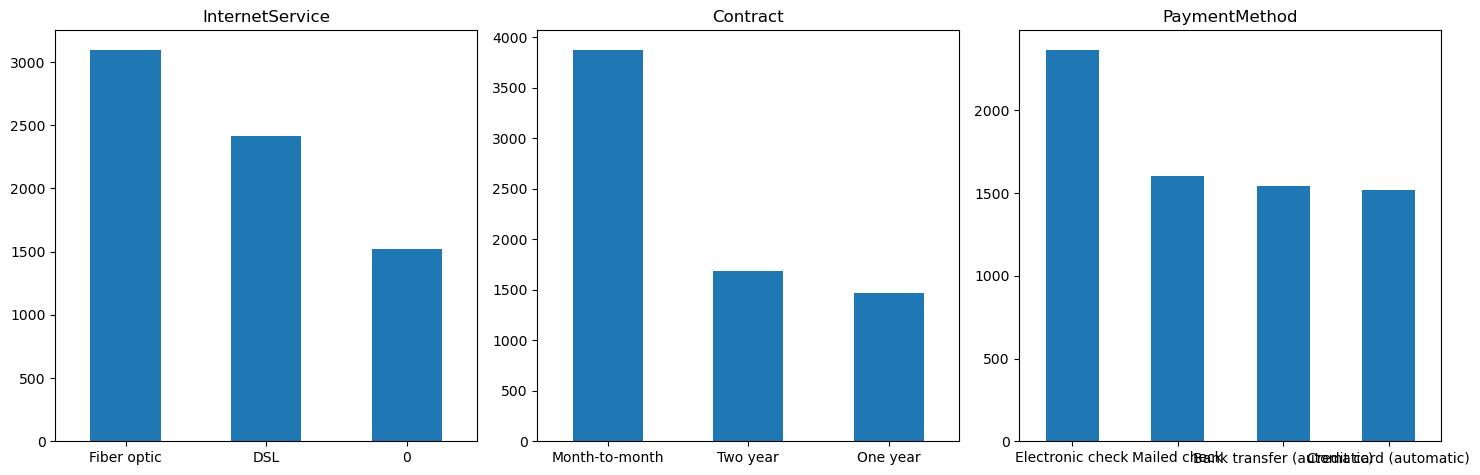

In [56]:
plot_columns_side_by_side(df, ["InternetService","Contract","PaymentMethod"])

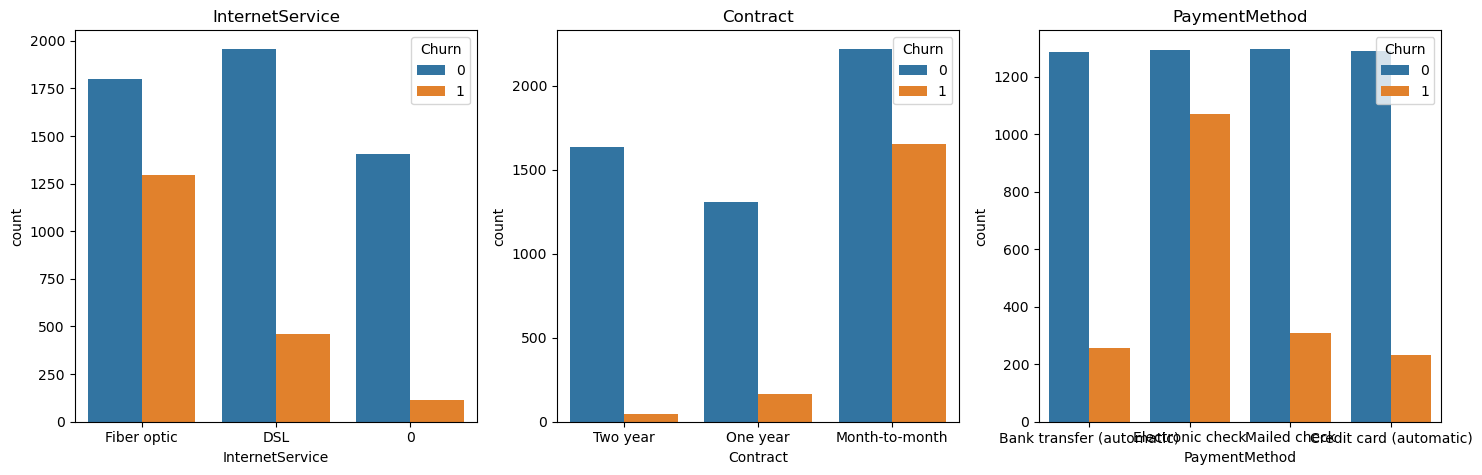

In [57]:
plot_columns_side_by_side(df, ["InternetService","Contract","PaymentMethod"], hue="Churn")

In [58]:
def plot_value_counts_cat(data, column_name, hue_column=None):
    """
    Plot value counts of unique categories in a column with an optional hue column.

    Parameters:
        data (pd.DataFrame): The DataFrame containing the data.
        column_name (str): The name of the column for which to plot value counts.
        hue_column (str, optional): The name of the hue column for grouped comparisons. Default is None.

    Returns:
        None
    """
    if hue_column:
        value_counts = data.groupby([column_name, hue_column]).size().unstack().fillna(0)
    else:
        value_counts = data[column_name].value_counts()

    x_labels = value_counts.index.astype(str)
    x = range(len(x_labels))
    
    bottom = None
    for hue_label in value_counts.columns:
        counts = value_counts[hue_label]
        plt.bar(x, counts, label=hue_label, bottom=bottom)
        
        if bottom is None:
            bottom = counts
        else:
            bottom += counts

    plt.xlabel(column_name)
    plt.ylabel('Count')
    plt.title(f'{column_name} x {hue_column}')
    plt.xticks(x, x_labels, rotation=45)  # Rotating x-axis labels for better readability
    
    plt.legend(title=hue_column)
    plt.show()

def plot_histogram_with_hue(data, column_name, hue_column=None):
    """
    Create a histogram-like plot with hue.

    Parameters:
        data (pd.DataFrame): The DataFrame containing the data.
        column_name (str): The name of the column for which to plot the histogram.
        hue_column (str, optional): The name of the hue column for grouped comparisons. Default is None.

    Returns:
        None
    """
    
    # Create a histogram-like plot with hue
    sns.histplot(data=data, x=column_name, hue=hue_column, multiple='stack', shrink=0.8)
    
    # Set labels and title
    plt.xlabel(column_name)
    plt.ylabel('Count')
    plt.title(f'{column_name} Histogram with {hue_column}')
    
    # Show the plot
    plt.show()

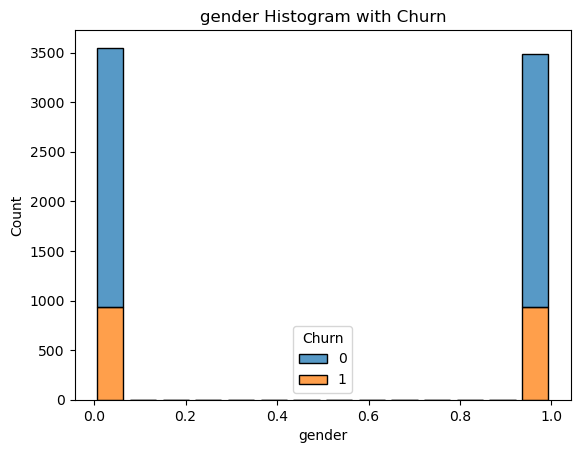

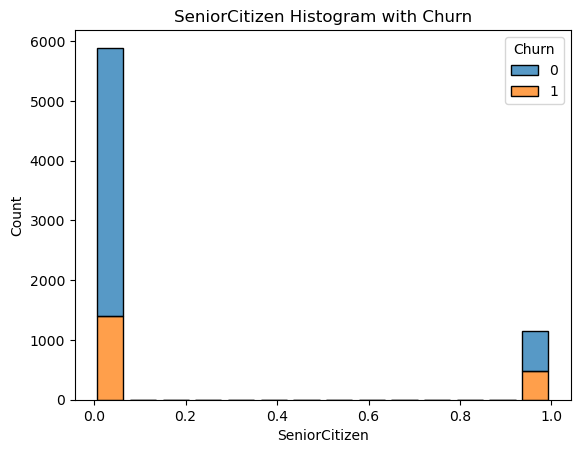

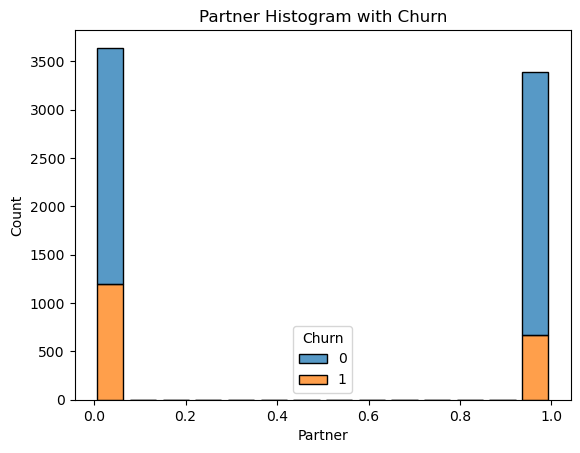

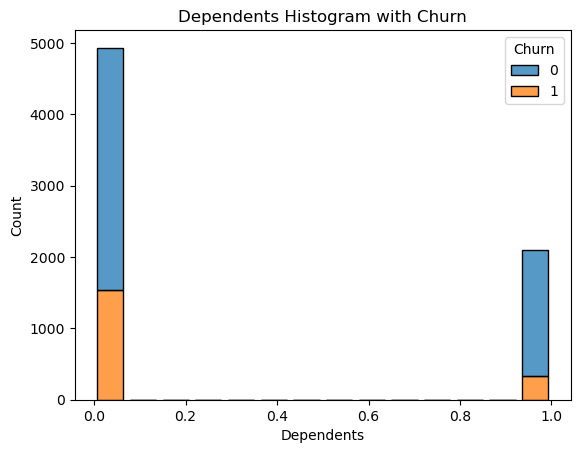

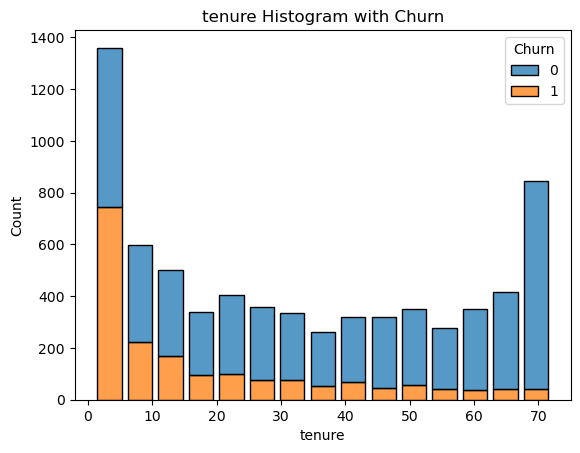

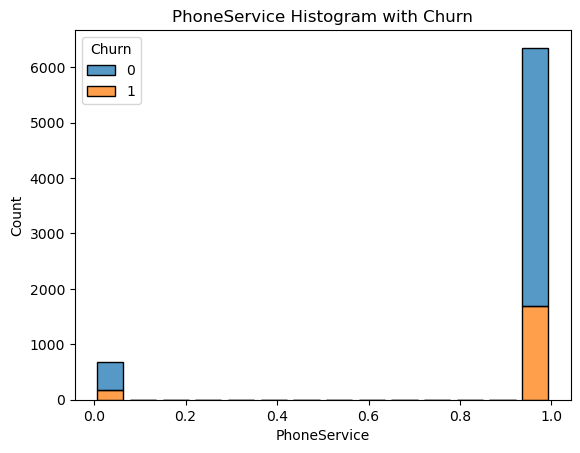

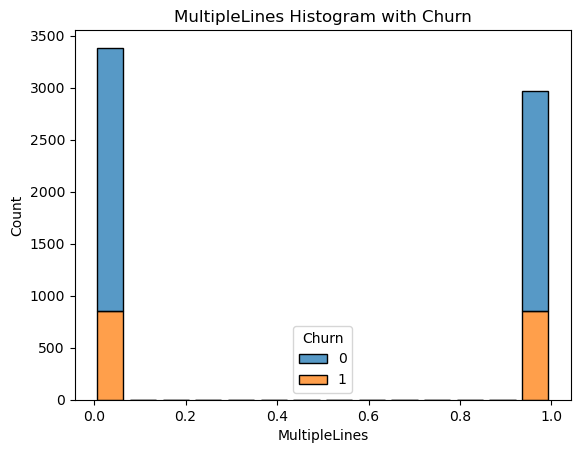

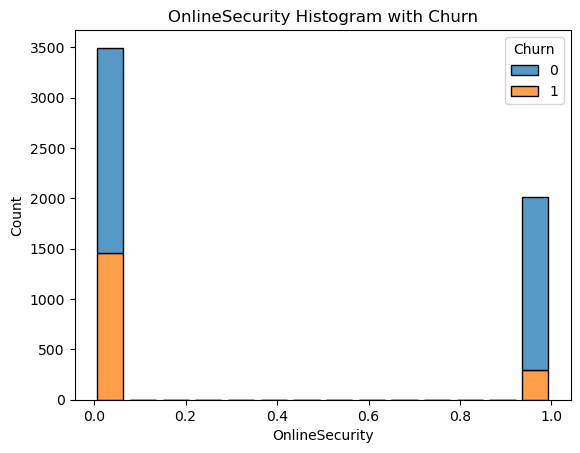

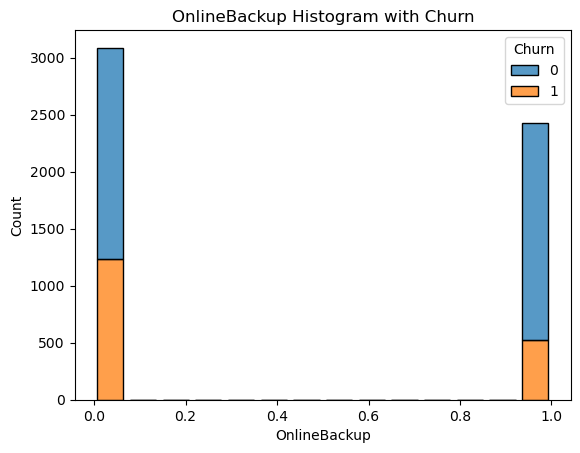

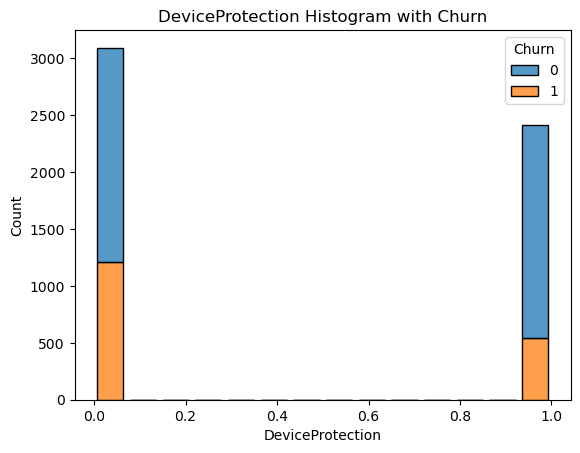

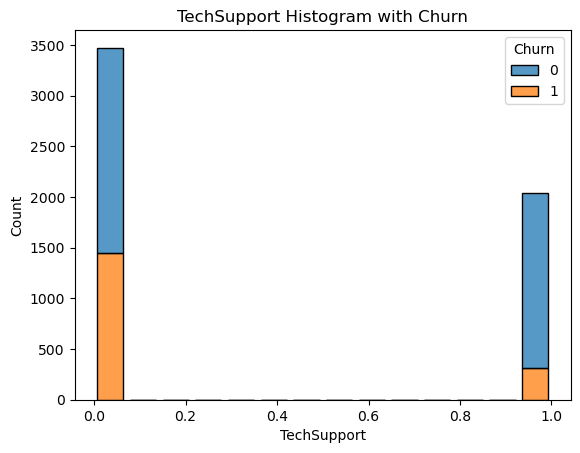

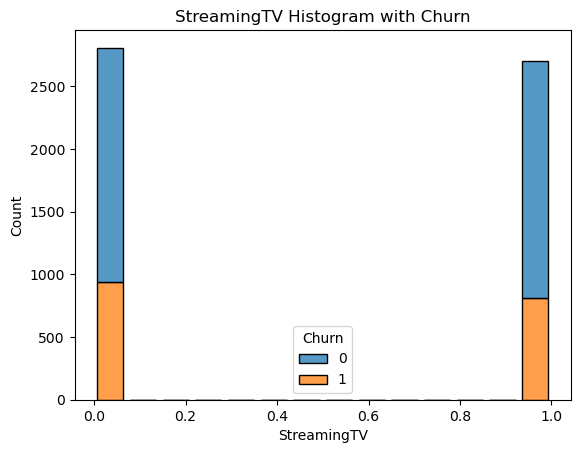

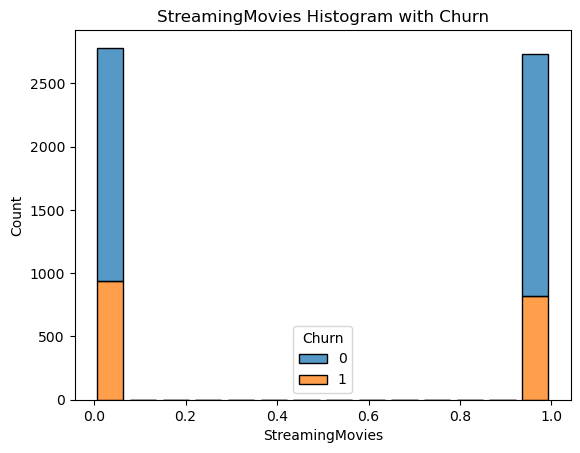

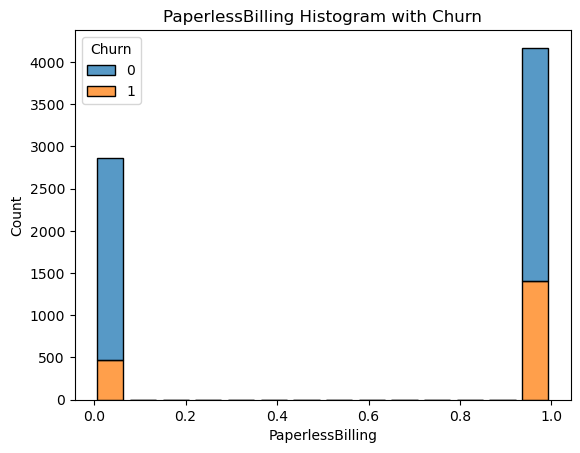

In [182]:
for col in df.select_dtypes(include=["int64","float64"]).columns.tolist():
    if (col != "Churn"):
        plot_histogram_with_hue(df, col, "Churn")

## Revenue

In [219]:
df["TotalCharges"].mean()

2283.3004408418706

In [227]:
churned["TotalCharges"].mean()

1531.796094168002

In [228]:
active["TotalCharges"].mean()

2555.3441410032933

## Correlation

Balancing classes is not a requirement for computing Pearson correlation. Pearson correlation is a measure of the linear relationship between two continuous variables. It quantifies the strength and direction of the linear association between two variables, such as their tendency to increase or decrease together.

<Axes: >

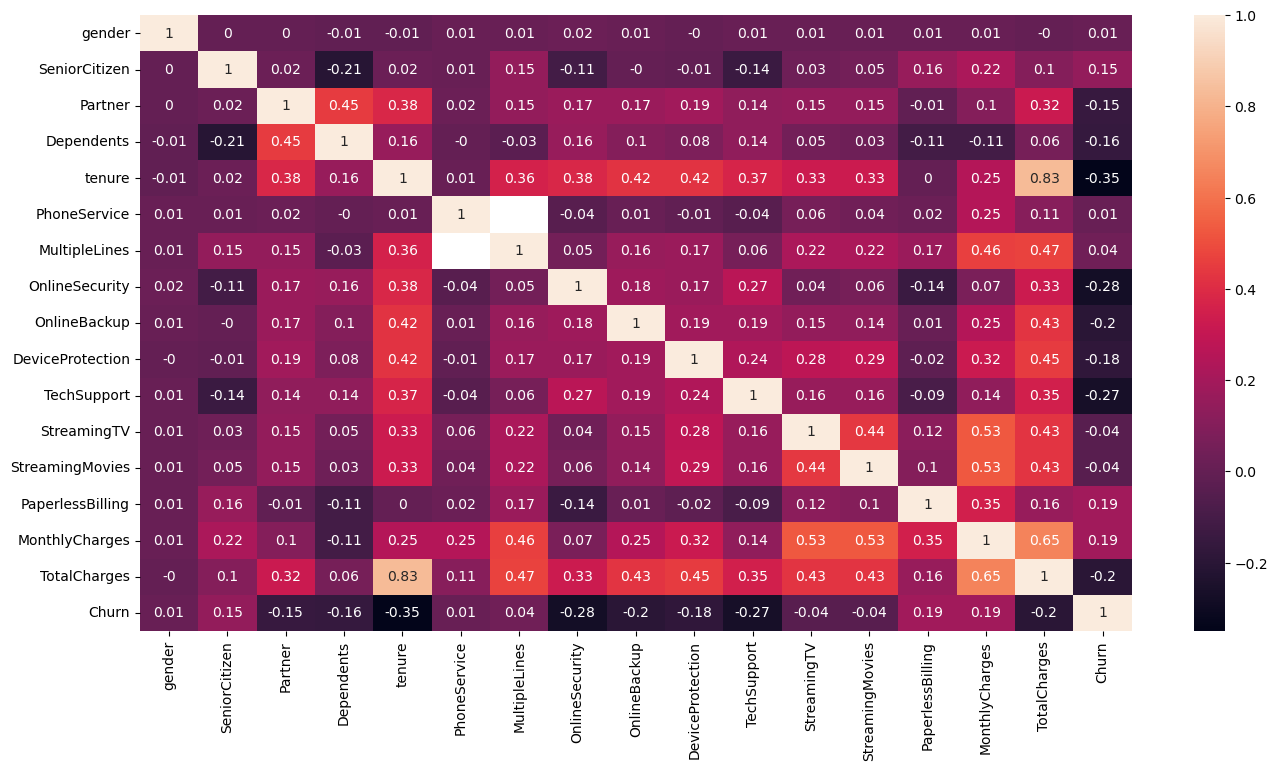

In [256]:
plt.figure(figsize=(16, 8))
sns.heatmap(df.corr().round(2), annot=True)

In [266]:
def calculate_point_biserial_correlation(df, binary_column, continuous_columns):
    """
    Calculate Point-Biserial Correlation for a list of continuous columns with a binary column.

    Args:
    - df (pandas.DataFrame): The DataFrame containing the data.
    - binary_column (str): The name of the binary column.
    - continuous_columns (list of str): List of column names for continuous variables.

    Returns:
    - result_df (pandas.DataFrame): A DataFrame containing the Point-Biserial Correlation coefficients,
      p-values, and interpretations for each continuous column.
    """
    results = []
    
    for column in continuous_columns:
        try:
            point_biserial_corr, p_value = stats.pointbiserialr(df[binary_column], df[column])
            
            # Interpretation based on correlation and p-value
            if p_value < 0.05:
                interpretation = "Significant"
            else:
                interpretation = "Not Significant"
            
            results.append([column, point_biserial_corr, p_value, interpretation])
        except:
            pass

    result_df = pd.DataFrame(results, columns=["Continuous_Variable", "Point-Biserial_Correlation", "P_Value", "Interpretation"])
    
    return result_df


In [275]:
df.loc[df["InternetService"] != 0].shape

(5512, 21)

In [277]:
df_hired_internet = df.loc[df["InternetService"] != 0]

In [278]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7569-NMZYQ,1,0,1,1,72,1,1.0,Fiber optic,1.0,1.0,1.0,1.0,1.0,1.0,Two year,1,Bank transfer (automatic),118.75,8672.45,0
1,8984-HPEMB,1,0,0,0,71,1,1.0,Fiber optic,1.0,1.0,1.0,1.0,1.0,1.0,Two year,1,Electronic check,118.65,8477.60,0
2,5989-AXPUC,1,0,1,0,68,1,1.0,Fiber optic,1.0,1.0,1.0,1.0,1.0,1.0,Two year,0,Mailed check,118.60,7990.05,0
3,5734-EJKXG,1,0,0,0,61,1,1.0,Fiber optic,1.0,1.0,1.0,1.0,1.0,1.0,One year,1,Electronic check,118.60,7365.70,0
4,8199-ZLLSA,0,0,0,0,67,1,1.0,Fiber optic,1.0,1.0,1.0,1.0,1.0,1.0,One year,1,Bank transfer (automatic),118.35,7804.15,1


In [281]:
calculate_point_biserial_correlation(df, "Churn", binary).sort_values("Point-Biserial_Correlation")

,Continuous_Variable,Point-Biserial_Correlation,P_Value,Interpretation
3,Dependents,-0.163128,3.896536e-43,Significant
2,Partner,-0.149982,1.171290e-36,Significant
0,gender,0.008545,4.737357e-01,Not Significant
4,PhoneService,0.011691,3.269553e-01,Not Significant
1,SeniorCitizen,0.150541,6.377295e-37,Significant
5,PaperlessBilling,0.191454,4.879248e-59,Significant
6,Churn,1.000000,0.000000e+00,Significant


In [282]:
calculate_point_biserial_correlation(df_hired_internet, "Churn", binary).sort_values("Point-Biserial_Correlation")

,Continuous_Variable,Point-Biserial_Correlation,P_Value,Interpretation
5,OnlineSecurity,-0.280508,3.365672e-100,Significant
8,TechSupport,-0.274112,1.364799e-95,Significant
6,OnlineBackup,-0.195758,9.673218e-49,Significant
7,DeviceProtection,-0.176806,6.052125e-40,Significant
2,Partner,-0.161626,1.408306e-33,Significant
3,Dependents,-0.147970,2.342520e-28,Significant
10,StreamingMovies,-0.040525,2.618977e-03,Significant
9,StreamingTV,-0.036698,6.432116e-03,Significant
0,gender,0.008608,5.228634e-01,Not Significant
4,PhoneService,0.055215,4.104376e-05,Significant


## Chi-squared 

In [35]:
def chi_squared_test(data1, data2):
    """
    Perform a chi-squared test on two categorical datasets and provide an interpretation.

    Args:
    - data1 (numpy.ndarray or list): First categorical dataset (e.g., a list of categories).
    - data2 (numpy.ndarray or list): Second categorical dataset (e.g., a list of categories).

    Returns:
    - chi2_statistic (float): The chi-squared test statistic.
    - p_value (float): The p-value associated with the test.
    - interpretation (str): An interpretation of the test result.
    """
    # Create contingency table from the two datasets
    observed_table = np.array([data1, data2])

    # Perform the chi-squared test
    chi2_statistic, p_value, _, _ = stats.chi2_contingency(observed_table)

    # Define the degrees of freedom
    degrees_of_freedom = (observed_table.shape[0] - 1) * (observed_table.shape[1] - 1)

    # Interpret the test result
    if p_value < 0.05:
        interpretation = f"Chi-squared statistic = {chi2_statistic:.2f}, p-value = {p_value:.4f}, Reject the null hypothesis. There is a significant association between the variables."
    else:
        interpretation = f"Chi-squared statistic = {chi2_statistic:.2f}, p-value = {p_value:.4f}, Fail to reject the null hypothesis. There is no significant association between the variables."

    return chi2_statistic, p_value, interpretation

In [36]:
df_hired_internet = df.loc[df["InternetService"] != 0]

In [37]:
chi_squared_test(df["Churn"], df["MonthlyCharges"])

(5516.550538704476,
 1.0,
 'Chi-squared statistic = 5516.55, p-value = 1.0000, Fail to reject the null hypothesis. There is no significant association between the variables.')

In [38]:
chi_squared_test(df["Churn"], df["TotalCharges"])

(96891.24115796921,
 0.0,
 'Chi-squared statistic = 96891.24, p-value = 0.0000, Reject the null hypothesis. There is a significant association between the variables.')

In [39]:
chi_squared_test(df_hired_internet["Churn"], df_hired_internet["MonthlyCharges"])

(4261.619650319802,
 1.0,
 'Chi-squared statistic = 4261.62, p-value = 1.0000, Fail to reject the null hypothesis. There is no significant association between the variables.')

In [40]:
chi_squared_test(df_hired_internet["Churn"], df_hired_internet["TotalCharges"])

(69109.20010291545,
 0.0,
 'Chi-squared statistic = 69109.20, p-value = 0.0000, Reject the null hypothesis. There is a significant association between the variables.')

In [46]:
def calculate_anova(df, binary_column, categorical_columns):
    """
    Perform Analysis of Variance (ANOVA) between a binary column and a list of categorical columns.

    Args:
    - df (pandas.DataFrame): The DataFrame containing the data.
    - binary_column (str): The name of the binary column.
    - categorical_columns (list of str): List of column names for categorical variables.

    Returns:
    - result_df (pandas.DataFrame): A DataFrame containing the F-statistic, p-value, and counts of churned and not churned people for each categorical column.
    """
    results = []
    
    for column in categorical_columns:
        churn_grouped = []
        
        for category in df[column].unique():
            churn_data = df[df[column] == category][binary_column]
            churned_count = (churn_data == 1).sum()
            not_churned_count = (churn_data == 0).sum()
            churn_grouped.append(churn_data)
            results.append([column, category, churned_count, not_churned_count])

    result_df = pd.DataFrame(results, columns=["Categorical_Variable", "Category", "Churned_Count", "Not_Churned_Count"])
    
    return result_df

In [47]:
calculate_anova(df, "Churn", more_two)

,Categorical_Variable,Category,Churned_Count,Not_Churned_Count
0,MultipleLines,1.0,850,2117
1,MultipleLines,0.0,849,2536
2,MultipleLines,NaN,0,0
3,InternetService,Fiber optic,1297,1799
4,InternetService,DSL,459,1957
5,InternetService,0,113,1407
6,OnlineSecurity,1.0,295,1720
7,OnlineSecurity,0.0,1461,2036
8,OnlineSecurity,NaN,0,0
9,OnlineBackup,1.0,523,1902


In [283]:
def calculate_anova(df, binary_column, categorical_columns, alpha=0.05):
    """
    Perform Analysis of Variance (ANOVA) between a binary column and a list of categorical columns.

    Args:
    - df (pandas.DataFrame): The DataFrame containing the data.
    - binary_column (str): The name of the binary column.
    - categorical_columns (list of str): List of column names for categorical variables.
    - alpha (float): The significance level (default is 0.05).

    Returns:
    - result_df (pandas.DataFrame): A DataFrame containing the F-statistic, p-value, and a column indicating significance.
    """
    results = []
    
    for column in categorical_columns:
        # Initialize an empty list to store binary values grouped by categories
        churn_grouped = []
        
        # Iterate through unique categories in the current categorical column
        for category in df[column].unique():
            # Append the binary values for each category to the churn_grouped list
            churn_grouped.append(df[df[column] == category][binary_column])
        
        # Calculate the F-statistic and p-value using ANOVA
        f_statistic, p_value = stats.f_oneway(*churn_grouped)
        
        # Determine significance based on the alpha threshold
        is_significant = p_value < alpha
        
        # Append the results (column name, F-statistic, p-value, significance) to the results list
        results.append([column, f_statistic, p_value, is_significant])

    # Create a DataFrame from the results list with appropriate column names
    result_df = pd.DataFrame(results, columns=["Categorical_Variable", "F_Statistic", "P_Value", "Significant"])
    
    # Return the DataFrame containing ANOVA results
    return result_df

In [289]:
anova0 = calculate_anova(df, "Churn", few_cat)

In [293]:
anova0

,Categorical_Variable,F_Statistic,P_Value,Significant
0,InternetService,406.294949,1.056959e-167,True
1,Contract,708.337681,5.633990e-281,True
2,PaymentMethod,236.751040,2.414992e-146,True


In [290]:
anova1 = calculate_anova(df_hired_internet, "Churn", few_cat)

In [294]:
anova1

,Categorical_Variable,F_Statistic,P_Value,Significant
0,InternetService,348.236251,2.079449e-75,True
1,Contract,510.441250,4.247361e-204,True
2,PaymentMethod,152.504352,6.012633e-95,True


In [291]:
append_values = []

# Iterate through significant categorical variables
for idx, row in anova1.iterrows():
    if row['Significant']:
        categorical_variable = row['Categorical_Variable']
        
        # Create a subset for each category within the variable
        categories = df[categorical_variable].unique()
        
        for category in categories:
            subset = df[df[categorical_variable] == category]
            churn_rate = subset['Churn'].mean()  # Churn rate within this category
            
            print(f"{categorical_variable} - {category}: Churn Rate = {churn_rate:.2%}")
            append_values.append([categorical_variable, category, churn_rate])

InternetService - Fiber optic: Churn Rate = 41.89%
InternetService - DSL: Churn Rate = 19.00%
InternetService - 0: Churn Rate = 7.43%
Contract - Two year: Churn Rate = 2.85%
Contract - One year: Churn Rate = 11.28%
Contract - Month-to-month: Churn Rate = 42.71%
PaymentMethod - Bank transfer (automatic): Churn Rate = 16.73%
PaymentMethod - Electronic check: Churn Rate = 45.29%
PaymentMethod - Mailed check: Churn Rate = 19.20%
PaymentMethod - Credit card (automatic): Churn Rate = 15.25%


In [292]:
pd.DataFrame(append_values).sort_values(2, ascending=False)

,0,1,2
7,PaymentMethod,Electronic check,0.452854
5,Contract,Month-to-month,0.427097
0,InternetService,Fiber optic,0.418928
8,PaymentMethod,Mailed check,0.192020
1,InternetService,DSL,0.189983
6,PaymentMethod,Bank transfer (automatic),0.167315
9,PaymentMethod,Credit card (automatic),0.152531
4,Contract,One year,0.112772
2,InternetService,0,0.074342
3,Contract,Two year,0.028487


In [53]:
append_values = []

# Iterate through significant categorical variables
for idx, row in anova0.iterrows():
    if row['Significant']:
        categorical_variable = row['Categorical_Variable']
        
        # Create a subset for each category within the variable
        categories = df[categorical_variable].unique()
        
        for category in categories:
            subset = df[df[categorical_variable] == category]
            churn_rate = subset['Churn'].mean()  # Churn rate within this category
            
            print(f"{categorical_variable} - {category}: Churn Rate = {churn_rate:.2%}")
            append_values.append([categorical_variable, category, churn_rate])

InternetService - Fiber optic: Churn Rate = 41.89%
InternetService - DSL: Churn Rate = 19.00%
InternetService - 0: Churn Rate = 7.43%
Contract - Two year: Churn Rate = 2.85%
Contract - One year: Churn Rate = 11.28%
Contract - Month-to-month: Churn Rate = 42.71%
PaymentMethod - Bank transfer (automatic): Churn Rate = 16.73%
PaymentMethod - Electronic check: Churn Rate = 45.29%
PaymentMethod - Mailed check: Churn Rate = 19.20%
PaymentMethod - Credit card (automatic): Churn Rate = 15.25%


In [54]:
pd.DataFrame(append_values).sort_values(2, ascending=False)

,0,1,2
7,PaymentMethod,Electronic check,0.452854
5,Contract,Month-to-month,0.427097
0,InternetService,Fiber optic,0.418928
8,PaymentMethod,Mailed check,0.192020
1,InternetService,DSL,0.189983
6,PaymentMethod,Bank transfer (automatic),0.167315
9,PaymentMethod,Credit card (automatic),0.152531
4,Contract,One year,0.112772
2,InternetService,0,0.074342
3,Contract,Two year,0.028487


# Churn prediction

In [313]:
df = pd.read_csv("/Users/anasouza/Documents/A3Data/churn_telefone/Customer-Churn - Customer-Churn.csv")
df = df.dropna()

In [315]:
def process_dataframe_columns_modeling(df):
    """
    Process columns in a DataFrame with two or more but less than five unique values.

    Args:
        df (pd.DataFrame): The input DataFrame to process.

    Returns:
        None: The function modifies the input DataFrame in place.
    """
    # Identify columns with only two unique values
    num_uniques = pd.DataFrame(df.nunique())
    only_two = num_uniques.loc[num_uniques[0] == 2].index.tolist()

    # Replace specific values in columns with two unique values
    for col in only_two:
        df[col] = df[col].replace({"Yes": 1, "No": 0, "Female": 1, "Male": 0})

    # Convert columns with two unique values to integer type
    for col in only_two:
        try:
            df[col] = df[col].astype(int)
        except:
            pass

    # Identify columns with more than two but less than five unique values
    more_than_two_less_than_five = num_uniques.loc[(num_uniques[0] > 2) & (num_uniques[0] < 5)].index.tolist()

    # Replace specific values in columns with more than two but less than five unique values
    for col in more_than_two_less_than_five:
        df[col] = df[col].replace({"Yes": 1, "No": 0})

    # Convert columns with more than two but less than five unique values to integer type
    for col in more_than_two_less_than_five:
        try:
            df[col] = df[col].astype(int)
        except:
            pass

    df["MonthlyCharges"] = df["MonthlyCharges"].str.replace(",",".")
    df["TotalCharges"] = df["TotalCharges"].str.replace(",",".")

    df["MonthlyCharges"]  = df["MonthlyCharges"].astype(float)
    df["TotalCharges"]  = df["TotalCharges"].astype(float)


In [316]:
process_dataframe_columns_modeling(df)

In [317]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_columns = [col for col in categorical_columns if "ID" not in col]
data_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

In [318]:
data_encoded.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_1,MultipleLines_No phone service,InternetService_DSL,InternetService_Fiber optic,OnlineSecurity_1,OnlineSecurity_No internet service,OnlineBackup_1,OnlineBackup_No internet service,DeviceProtection_1,DeviceProtection_No internet service,TechSupport_1,TechSupport_No internet service,StreamingTV_1,StreamingTV_No internet service,StreamingMovies_1,StreamingMovies_No internet service,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7569-NMZYQ,1,0,1,1,72,1,1,118.75,8672.45,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0,0
1,8984-HPEMB,1,0,0,0,71,1,1,118.65,8477.60,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,0
2,5989-AXPUC,1,0,1,0,68,1,0,118.60,7990.05,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0,1
3,5734-EJKXG,1,0,0,0,61,1,1,118.60,7365.70,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0
4,8199-ZLLSA,0,0,0,0,67,1,1,118.35,7804.15,1,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0


In [319]:
X = data_encoded.drop(["Churn","customerID"], axis=1)
y = data_encoded["Churn"]

In [320]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, make_scorer

In [321]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (5625, 30)
X_test shape: (1407, 30)
y_train shape: (5625,)
y_test shape: (1407,)


In [322]:
data_encoded.shape

(7032, 32)

In [324]:
from sklearn.dummy import DummyClassifier


In [325]:
# List of models including the Dummy Classifier
models = [
    ('Dummy Classifier', DummyClassifier(strategy='most_frequent', random_state=42)),
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),
    ('Decision Tree Weight', DecisionTreeClassifier(random_state=42, class_weight="balanced")),
    ('Random Forest Classifier', RandomForestClassifier(random_state=42)),
    ('Random Forest Classifier Weight', RandomForestClassifier(random_state=42, class_weight='balanced')),
    ('Logistic Regression', LogisticRegression(random_state=42)),
    ('Logistic Regression Weight', LogisticRegression(random_state=42, class_weight='balanced')),
    ('LightGBM', LGBMClassifier(random_state=42)),
    ('LightGBM Weight', LGBMClassifier(random_state=42, class_weight="balanced"))
]

In [326]:
def evaluate_models(X_train, X_test, y_train, y_test, models):
    """
    Evaluate machine learning models using pipelines.

    Parameters:
    X_train (pd.DataFrame): Training features.
    X_test (pd.DataFrame): Testing features.
    y_train (pd.Series): Training labels.
    y_test (pd.Series): Testing labels.
    models (list of tuples): List of model names and instances, e.g., [('Model Name', Model())].

    Returns:
    pd.DataFrame: A DataFrame containing evaluation metrics for each model.
    """
    # Define numerical and categorical columns
    numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = list(set(X_train.columns) - set(numerical_cols))
    
    # Create a ColumnTransformer for preprocessing
    preprocessor_minmax = ColumnTransformer(
        transformers=[
            ('num', MinMaxScaler(), numerical_cols)
        ],
        remainder='passthrough'
    )
    
    # Results DataFrame to store model evaluation metrics
    results_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
    
    scalers = [('MinMaxScaler', preprocessor_minmax)]
    
    for scaler_name, preprocessor in scalers:
        for model_name, model in models:
            model_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
            model_pipeline.fit(X_train, y_train)
            y_pred = model_pipeline.predict(X_test)
    
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
    
            results_df = results_df.append({'Model': model_name, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1}, ignore_index=True)
    
    results_df = results_df.sort_values(["Precision"], ascending=False)
    return results_df

In [327]:
evaluate_models(X_train, X_test, y_train, y_test, models)


/Users/anasouza/opt/anaconda3/envs/ambev/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/var/folders/c7/n7fskkg1029g6xhbfw1vpc8c0000gn/T/ipykernel_7846/2678919151.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Model': model_name, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1}, ignore_index=True)
/var/folders/c7/n7fskkg1029g6xhbfw1vpc8c0000gn/T/ipykernel_7846/2678919151.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Model': model_name, 'Accuracy': accuracy, 'Precision': prec

,Model,Accuracy,Precision,Recall,F1-Score
4,Random Forest Classifier Weight,0.770434,0.597270,0.460526,0.520059
7,LightGBM,0.773987,0.592814,0.521053,0.554622
3,Random Forest Classifier,0.766880,0.583871,0.476316,0.524638
5,Logistic Regression,0.768301,0.577586,0.528947,0.552198
8,LightGBM Weight,0.740583,0.513915,0.728947,0.602829
6,Logistic Regression Weight,0.733475,0.504146,0.800000,0.618515
2,Decision Tree Weight,0.727790,0.496000,0.489474,0.492715
1,Decision Tree,0.720682,0.483204,0.492105,0.487614
0,Dummy Classifier,0.729922,0.000000,0.000000,0.000000


In [89]:

import lightgbm as lgb
from bayes_opt import BayesianOptimization

In [90]:
dtrain = lgb.Dataset(data=X_train ,label=y_train)


In [94]:
def hyp_lgbm(num_leaves, 
             feature_fraction, 
             bagging_fraction, 
             max_depth,
             min_split_gain,
             min_child_weight):
    """
    Hyperparameter optimization objective function for LightGBM using cross-validation.
    
    Parameters:
    - num_leaves (float): Number of leaves in the LightGBM tree.
    - feature_fraction (float): Fraction of features to consider during tree construction.
    - bagging_fraction (float): Fraction of data to use for bagging (random sampling).
    - max_depth (float): Maximum depth of the LightGBM tree.
    - min_split_gain (float): Minimum loss reduction required for a split to occur.
    - min_child_weight (float): Minimum sum of instance weight (hessian) in a child.
    
    Returns:
    - float: Negative of the minimum AUC score achieved during cross-validation.
    """
    params = {
        'num_iterations': 5000,
        'learning_rate': 0.05,
        'early_stopping_rounds': 50,  # Early stopping based on validation performance
        'metric': 'auc'
    }

    params["num_leaves"] = int(round(num_leaves))
    params['feature_fraction'] = max(min(feature_fraction, 1), 0)
    params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
    params['max_depth'] = int(round(max_depth))
    params['min_split_gain'] = min_split_gain
    params['min_child_weight'] = min_child_weight
    params['class_weight'] = 'balanced'

    dtrain = lgb.Dataset(X_train, label=y_train)
    
    cv_result = lgb.cv(params,
                       dtrain,
                       nfold=5,
                       seed=42,
                       stratified=True,
                       metrics=['auc'],
                       verbose_eval=None,
                       callbacks=[lgb.early_stopping(50, verbose=False)])  # Early stopping callback
    
    return -np.min(cv_result['auc-mean'])

In [95]:
pds = {'num_leaves': (45, 60),
          'feature_fraction': (0.1, 0.9),
          'bagging_fraction': (0.8, 1),
          'max_depth': (9, 13),
          'min_split_gain': (0.001, 0.1),
          'min_child_weight': (30, 50)
          }

In [96]:
optimizer = BayesianOptimization(hyp_lgbm,pds,random_state=7)
                                  

optimizer.maximize(init_points=5, n_iter=15)

|   iter    |  target   | baggin... | featur... | max_depth | min_ch... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 621
[LightGBM] [Info] Number of data points in the train set: 3092, number of used features: 22
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Auto-choosing row-wise multi-th

/Users/anasouza/opt/anaconda3/envs/ambev/lib/python3.10/site-packages/lightgbm/engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/anasouza/opt/anaconda3/envs/ambev/lib/python3.10/site-packages/lightgbm/engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/anasouza/opt/anaconda3/envs/ambev/lib/python3.10/site-packages/lightgbm/engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/anasouza/opt/anaconda3/envs/ambev/lib/python3.10/site-packages/lightgbm/engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/anasouza/opt/anaconda3/envs/ambev/lib/python3.10/site-packages/lightgbm/engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/anasouza/opt/anaconda3/envs/ambev/lib/python3.10/site-packages/lightgbm/engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 621
[LightGBM] [Info] Number of data points in the train set: 3092, number of used features: 22
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 621
[LightGBM] [Info] Number of data points in the train set: 3092, number of used features: 22
[LightGBM] [Warning] U

/Users/anasouza/opt/anaconda3/envs/ambev/lib/python3.10/site-packages/lightgbm/engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 621
[LightGBM] [Info] Number of data points in the train set: 3092, number of used features: 22
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 621
[LightGBM] [Info] Number of data points in the train set: 3092, number of used features: 22
[LightGBM] [Warning] U

/Users/anasouza/opt/anaconda3/envs/ambev/lib/python3.10/site-packages/lightgbm/engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 621
[LightGBM] [Info] Number of data points in the train set: 3092, number of used features: 22
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 621
[LightGBM] [Info] Number of data points in the tra

/Users/anasouza/opt/anaconda3/envs/ambev/lib/python3.10/site-packages/lightgbm/engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 621
[LightGBM] [Info] Number of data points in the train set: 3092, number of used features: 22
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 621
[LightGBM] [Info] Number of data points in the train set: 3092, number of used features: 22
[LightGBM] [Warning] U

/Users/anasouza/opt/anaconda3/envs/ambev/lib/python3.10/site-packages/lightgbm/engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 621
[LightGBM] [Info] Number of data points in the train set: 3092, number of used features: 22
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001790 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 621
[LightGBM] [Info] Number of data points in the train set: 3092, number of used features: 22
[LightGBM] [Warning] U

/Users/anasouza/opt/anaconda3/envs/ambev/lib/python3.10/site-packages/lightgbm/engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 621
[LightGBM] [Info] Number of data points in the train set: 3092, number of used features: 22
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 621
[LightGBM] [Info] Number of data points in the train set: 3092, number of used features: 22
[LightGBM] [Warning] U

/Users/anasouza/opt/anaconda3/envs/ambev/lib/python3.10/site-packages/lightgbm/engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 621
[LightGBM] [Info] Number of data points in the train set: 3092, number of used features: 22
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] T

/Users/anasouza/opt/anaconda3/envs/ambev/lib/python3.10/site-packages/lightgbm/engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 621
[LightGBM] [Info] Number of data points in the train set: 3092, number of used features: 22
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 621
[LightGBM] [Info] Number of data points in the train set: 3092, number of used features: 22
[LightGBM] [Warning] U

/Users/anasouza/opt/anaconda3/envs/ambev/lib/python3.10/site-packages/lightgbm/engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 621
[LightGBM] [Info] Number of data points in the train set: 3092, number of used features: 22
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 621
[LightGBM] [Info] Number of data points in the train set: 3092, number of used features: 22
[LightGBM] [Warning] U

/Users/anasouza/opt/anaconda3/envs/ambev/lib/python3.10/site-packages/lightgbm/engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 621
[LightGBM] [Info] Number of data points in the train set: 3092, number of used features: 22
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 621
[LightGBM] [Info] Number of data points in the train set: 3092, number of used features: 22
[LightGBM] [Warning] U

/Users/anasouza/opt/anaconda3/envs/ambev/lib/python3.10/site-packages/lightgbm/engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Start training from score 0.331177
[LightGBM] [Info] Start training from score 0.331177
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score 0.331177
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score 0.331177
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/Users/anasouza/opt/anaconda3/envs/ambev/lib/python3.10/site-packages/lightgbm/engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 621
[LightGBM] [Info] Number of data points in the train set: 3092, number of used features: 22
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 621
[LightGBM] [Info] Number of data points in the tra

/Users/anasouza/opt/anaconda3/envs/ambev/lib/python3.10/site-packages/lightgbm/engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000543 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 621
[LightGBM] [Info] Number of data points in the train set: 3092, number of used features: 22
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 621
[LightGBM] [Info] Number of data points in the tra

/Users/anasouza/opt/anaconda3/envs/ambev/lib/python3.10/site-packages/lightgbm/engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 621
[LightGBM] [Info] Number of data points in the train set: 3092, number of used features: 22
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] T

/Users/anasouza/opt/anaconda3/envs/ambev/lib/python3.10/site-packages/lightgbm/engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score 0.331177
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score 0.331177
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score 0.331177
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score 0.331177
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

In [98]:
opt_results = pd.DataFrame(optimizer.res)
opt_results = opt_results.sort_values("target").head()
opt_results

,target,params
0,-0.801155,"{'bagging_fraction': 0.8152616578747914, 'feature_fraction': 0.7239350337920917, 'max_depth': 10.753636925763574, 'min_child_weight': 44.469303556618826, 'min_split_gain': 0.09782096168766367, 'num_leaves': 53.07743805615651}"
7,-0.801015,"{'bagging_fraction': 0.8, 'feature_fraction': 0.9, 'max_depth': 9.0, 'min_child_weight': 50.0, 'min_split_gain': 0.1, 'num_leaves': 53.79567453373721}"
16,-0.800338,"{'bagging_fraction': 0.9866500954997991, 'feature_fraction': 0.8045156605063842, 'max_depth': 10.764252858334533, 'min_child_weight': 49.567139153768835, 'min_split_gain': 0.004661256797328348, 'num_leaves': 51.353514105977496}"
11,-0.795791,"{'bagging_fraction': 1.0, 'feature_fraction': 0.9, 'max_depth': 9.0, 'min_child_weight': 40.44947634969582, 'min_split_gain': 0.001, 'num_leaves': 59.220873475244}"
15,-0.795752,"{'bagging_fraction': 0.9039979690238297, 'feature_fraction': 0.732150393552882, 'max_depth': 11.761239246711444, 'min_child_weight': 36.39485120539619, 'min_split_gain': 0.023837410576991146, 'num_leaves': 58.49581893849777}"


In [102]:
new_dict = opt_results.iloc[0,1]

In [103]:
new_dict

{'bagging_fraction': 0.8152616578747914,
 'feature_fraction': 0.7239350337920917,
 'max_depth': 10.753636925763574,
 'min_child_weight': 44.469303556618826,
 'min_split_gain': 0.09782096168766367,
 'num_leaves': 53.07743805615651}

In [104]:
new_dict = {'bagging_fraction': 0.8,
 'feature_fraction': 0.72,
 'max_depth': 10,
 'min_child_weight': 44,
 'min_split_gain': 0.09,
 'num_leaves': 53,
 'class_weight': 'is_unballanced'}

In [105]:
import lightgbm
from sklearn import metrics

fit = lightgbm.Dataset(X_train, y_train)
val = lightgbm.Dataset(X_test, y_test, reference=fit)

model = lightgbm.train(
    params=new_dict,
    train_set=fit,
    num_boost_round=10000,
    valid_sets=(fit, val),
    valid_names=('fit', 'val'),
    early_stopping_rounds=20,
    verbose_eval=100
)

y_pred = model.predict(X_test)

print()
print(f"Test's ROC AUC: {metrics.roc_auc_score(y_test, y_pred):.5f}")
print(f"Test's logloss: {metrics.log_loss(y_test, y_pred):.5f}")

/Users/anasouza/opt/anaconda3/envs/ambev/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/anasouza/opt/anaconda3/envs/ambev/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 621
[LightGBM] [Info] Number of data points in the train set: 3865, number of used features: 22
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 0.331177
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

/Users/anasouza/opt/anaconda3/envs/ambev/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/anasouza/opt/anaconda3/envs/ambev/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 621
[LightGBM] [Info] Number of data points in the train set: 3865, number of used features: 22
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 0.331177
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

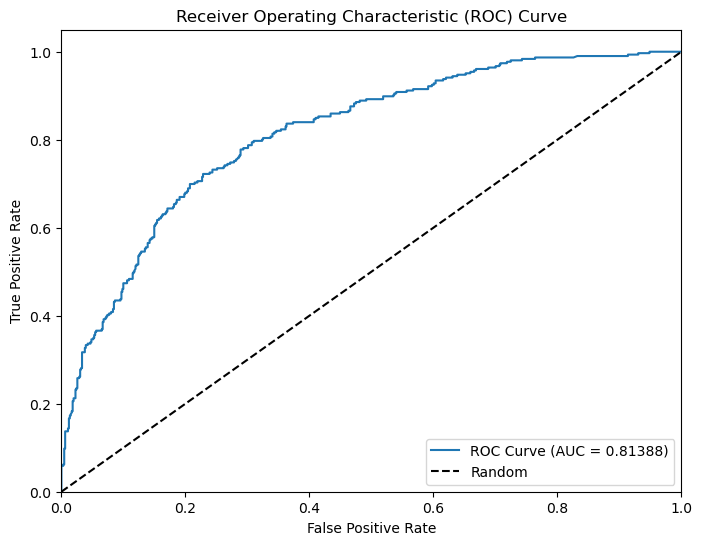

,Metric,Value
0,ROC AUC,0.813881
1,Log Loss,0.478322
2,KS Metric,0.493780


In [106]:
import lightgbm
from sklearn import metrics
import matplotlib.pyplot as plt
import pandas as pd


fit = lightgbm.Dataset(X_train, y_train)
val = lightgbm.Dataset(X_test, y_test, reference=fit)

model = lightgbm.train(
    params=new_dict,
    train_set=fit,
    num_boost_round=10000,
    valid_sets=(fit, val),
    valid_names=('fit', 'val'),
    early_stopping_rounds=20,
    verbose_eval=100
)

y_pred = model.predict(X_test)

# Calculate metrics
roc_auc = metrics.roc_auc_score(y_test, y_pred)
log_loss = metrics.log_loss(y_test, y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
ks_metric = max(tpr - fpr)

# Plot the ROC curve with AUC value
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.5f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
             
plt.show()

# Display metrics in a table
metrics_table = pd.DataFrame({
    'Metric': ['ROC AUC', 'Log Loss', 'KS Metric'],
    'Value': [roc_auc, log_loss, ks_metric]
})

metrics_table

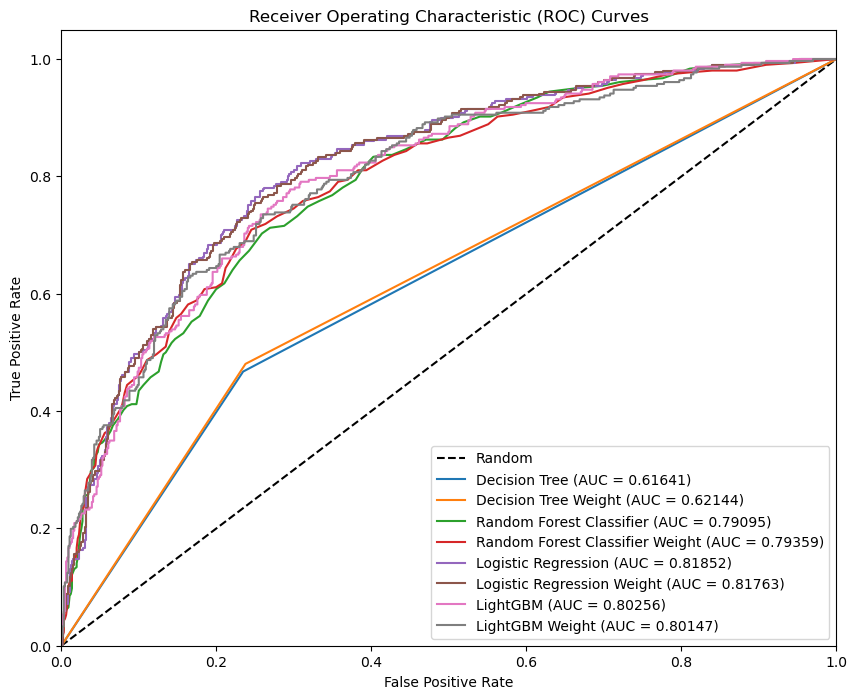

,Model,ROC AUC,Log Loss,KS Metric
0,Decision Tree,0.616414,11.853032,0.232827
1,Decision Tree Weight,0.621437,11.778484,0.242873
2,Random Forest Classifier,0.790946,0.539627,0.443915
3,Random Forest Classifier Weight,0.793591,0.570919,0.464067
4,Logistic Regression,0.818521,0.477457,0.519321
5,Logistic Regression Weight,0.817626,0.519675,0.505948
6,LightGBM,0.802564,0.500557,0.482770
7,LightGBM Weight,0.801472,0.529391,0.475082


In [107]:
import lightgbm
from sklearn import metrics
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier


models = [
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),
    ('Decision Tree Weight', DecisionTreeClassifier(random_state=42, class_weight="balanced")),
    ('Random Forest Classifier', RandomForestClassifier(random_state=42)),
    ('Random Forest Classifier Weight', RandomForestClassifier(random_state=42, class_weight='balanced')),
    ('Logistic Regression', LogisticRegression(random_state=42)),
    ('Logistic Regression Weight', LogisticRegression(random_state=42, class_weight='balanced')),
    ('LightGBM', LGBMClassifier(random_state=42)),
    ('LightGBM Weight', LGBMClassifier(random_state=42, class_weight="balanced"))
]

plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--', label='Random')


metrics_data = []

for model_name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]
    
    roc_auc = metrics.roc_auc_score(y_test, y_pred)
    log_loss = metrics.log_loss(y_test, y_pred)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    ks_metric = max(tpr - fpr)
    
    metrics_data.append([model_name, roc_auc, log_loss, ks_metric])
    
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.5f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()

metrics_table = pd.DataFrame(metrics_data, columns=['Model', 'ROC AUC', 'Log Loss', 'KS Metric'])
metrics_table

In [110]:
from sklearn.ensemble import VotingClassifier

In [115]:
# Initialize dictionaries to store metrics for each model
metrics_dict = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'ROC AUC': []
}

# Train and evaluate each model
for model_name, model in models:
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test data
    model_predictions = model.predict(X_test)
    
    # Calculate metrics for the model
    accuracy = accuracy_score(y_test, model_predictions)
    precision = precision_score(y_test, model_predictions)
    recall = recall_score(y_test, model_predictions)
    roc_auc = roc_auc_score(y_test, model_predictions)
    
    # Store metrics in the dictionary
    metrics_dict['Model'].append(model_name)
    metrics_dict['Accuracy'].append(accuracy)
    metrics_dict['Precision'].append(precision)
    metrics_dict['Recall'].append(recall)
    metrics_dict['ROC AUC'].append(roc_auc)

# Combine individual model predictions into an ensemble
ensemble_model = VotingClassifier(estimators=models, voting='hard')
ensemble_model.fit(X_train, y_train)
ensemble_predictions = ensemble_model.predict(X_test)

# Calculate metrics for the ensemble
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
ensemble_precision = precision_score(y_test, ensemble_predictions)
ensemble_recall = recall_score(y_test, ensemble_predictions)
ensemble_roc_auc = roc_auc_score(y_test, ensemble_predictions)

# Store ensemble metrics in a dictionary
ensemble_metrics_dict = {
    'Model': ['Ensemble'],
    'Accuracy': [ensemble_accuracy],
    'Precision': [ensemble_precision],
    'Recall': [ensemble_recall],
    'ROC AUC': [ensemble_roc_auc]
}

# Create DataFrames from the dictionaries
metrics_df = pd.DataFrame(metrics_dict)
ensemble_metrics_df = pd.DataFrame(ensemble_metrics_dict)

In [116]:
metrics_df

,Model,Accuracy,Precision,Recall,ROC AUC
0,Decision Tree,0.671148,0.479866,0.467320,0.616414
1,Decision Tree Weight,0.673216,0.483553,0.480392,0.621437
2,Random Forest Classifier,0.745605,0.632743,0.467320,0.670876
3,Random Forest Classifier Weight,0.762151,0.671171,0.486928,0.688245
4,Logistic Regression,0.769390,0.661479,0.555556,0.711968
5,Logistic Regression Weight,0.751810,0.583756,0.751634,0.751763
6,LightGBM,0.754912,0.632184,0.539216,0.696991
7,LightGBM Weight,0.736298,0.568733,0.689542,0.723742


In [117]:
ensemble_metrics_df

,Model,Accuracy,Precision,Recall,ROC AUC
0,Ensemble,0.763185,0.657143,0.526144,0.699532
